# Evaluating Player Similarity Predictions

In our previous experiments, our results are not reliable due to our training data crossing with test data!

To simulate what would happen realistically, we need to split train and test data before we start our similarity pairing & prediction.


In [1]:
import warnings
from pathlib import Path

from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic
from opal.score.similarity import SimilarityModel

if True:
    # PyCharm linting keeps wrecking this import, so it's in a True cond
    pass

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.2,
    unpopular_plays_thres=0.2,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 279765
by_unpopular_plays 279765 -> 75055
by_acc_filter 75055 -> 74961
by_remove_mod 74961 -> 71327
Users Left: 291 | Beatmaps Left: 718


In [2]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

skf = StratifiedKFold()
stratify = df['year'].astype(str) + "_" + df['user_id'].astype(str) + "_" + df['map_id'].astype(str)
mses = []
r2s = []
for train_ix, test_ix in skf.split(df, stratify):
    train_df, test_df = df.iloc[train_ix], df.iloc[test_ix],
    sim = SimilarityModel().fit(train_df)

    actuals, preds = [], []
    for ix, test_score in tqdm(test_df.iterrows()):
        try:
            pred = sim.predict(
                test_score['user_id'],
                test_score['year'],
                test_score['map_id']
            )
        except ZeroDivisionError or Exception:
            continue
        actuals.append(test_score['accuracy'])
        preds.append(pred)

    mse = mean_squared_error(actuals, preds, squared=False)
    r2 = r2_score(actuals, preds)
    mses.append(mse)
    r2s.append(r2)

100%|██████████| 65703/65703 [04:50<00:00, 226.18it/s]
14266it [03:33, 66.83it/s]
 13%|█▎        | 8782/65703 [00:36<03:57, 240.06it/s]


KeyboardInterrupt: 

In [ ]:
actuals, preds = [], []
for ix, test_score in tqdm(test_df.iterrows()):
    try:
        pred = sim.predict(test_score['user_id'], test_score['year'], test_score['map_id'])
    except:
        continue
    actuals.append(test_score['accuracy'])
    preds.append(pred)
    break

1525it [05:03, 66.89it/s]

In [4]:
mse = mean_squared_error(actuals, preds, squared=False)

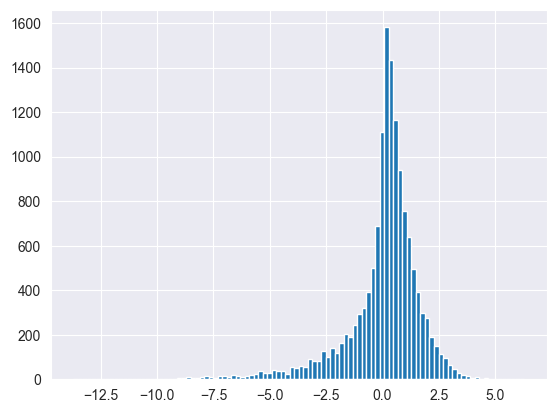

In [5]:
import matplotlib.pyplot as plt
import numpy as np
_=plt.hist(100 * (np.array(actuals) - np.array(preds)),bins=100)

Let's quickly remind ourselves of the functionalities.

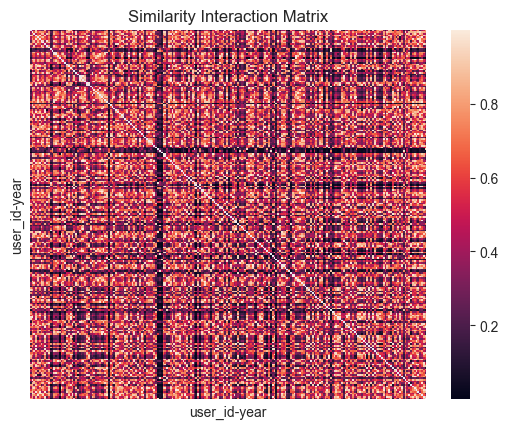

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

_ = sns.heatmap(sim.params.df_sim, yticklabels=False, xticklabels=False)
_ = plt.title("Similarity Interaction Matrix")

In [3]:
sim.params.df_scores



map_id  accuracy  accuracy_qt
user_id  year                                
65724    2020   364220  0.964168     0.327893
         2020   429550  0.942615     0.140781
         2020   429552  0.934411     0.094013
         2020   517247  0.965083     0.338289
         2020   532796  0.957360     0.257219
...                ...       ...          ...
20695135 2021  2177638  0.953561     0.222800
         2021  2204991  0.953703     0.224136
         2021  2220504  0.965944     0.348437
         2021  2384814  0.990764     0.770949
         2021  2387330  0.964048     0.326757

[27942 rows x 3 columns]

In [4]:
sim.predict(65724, 2020, 365902)

0.9473569051170906

In [ ]:
sns.scatterplot(pred['accuracy'], pred['predict_a'], s=2,
                alpha=0.3)
_ = plt.plot([0, 1], [0, 1], color='black', linestyle='dashed',
             linewidth=1, label='Perfect Prediction')
_ = plt.xlim([0.85, 1])
_ = plt.ylim([0.85, 1])
_ = plt.xlabel("Actual Accuracy")
_ = plt.ylabel("Predicted Accuracy")
_ = plt.legend()
_ = plt.title("Predict vs. Actual Accuracies")

In [ ]:
from opal.score.similarity.similarity import evaluate

evaluate(pred['accuracy'], pred['predict'])
evaluate(pred['accuracy'], pred['predict_a'])

## Effect of Support

Support is the number of players that have valid contributed to the calculation of similarity. Thus, they have >= `min_pair_plays`.

We're interested in finding out if support has any important impact on accuracy!

In [ ]:
import numpy as np
import pandas as pd

user_id = 65724
year = 2020
map_id = 429550

ix = (user_id, year)
df_user = df.loc[ix]
df_sim_user = pd.merge(
    df,
    df_sim.loc[ix].dropna().rename('similarity'),
    left_index=True, right_index=True
)
df_sim_user = df_sim_user[df_sim_user['map_id'] == map_id]
accuracy_qt_pred = np.average(
    df_sim_user['accuracy_qt'],
    weights=df_sim_user['similarity'] ** 8
)
accuracy_pred = qt.inverse_transform([[accuracy_qt_pred]])[0, 0]

In [ ]:
# If there are no similarities
if df_sim_user.empty:
    raise Exception("No Similarities")

# Within each map, we find weighted average (weighted by similarity)
# +--------+--------+------------+
# | map_id | acc_qt | similarity |
# +--------+---^----+------^-----+
#     (target) |           | (weights)
#              +-----------+
# This will yield us a SINGLE prediction per map_id

# We also COUNT the number of supports

# Join the prediction & support to the user df
df_user = df_user.merge(df_pred.rename('predict_qt'),
                        left_index=True, right_index=True)
df_user = df_user.merge(df_support.rename('support'),
                        left_index=True, right_index=True)

# Inverse transform the prediction_qt
df_user['predict'] = qt.inverse_transform(
    df_user[['predict_qt']].to_numpy()
)


In [ ]:
df.loc[ix].add_('map_id')